# Let's make it easy
The point of this notebook is to walk the user through a simple (non-hierarchical, non-multilevel) numpyro-based inference with a pendulum dataset.

## The dataset: simple pendulum
Using the position of a pendulum at one point in time from a collection of pendulums on two different planets, determine the values of L, $\theta$, and $a_g$ for each individual pendulum using a hierarchical setup.

In [1]:
## first, import all the necessary modules
import arviz as az
import corner
import graphviz
import jax
from jax import random
import jax.numpy as jnp # yes i know this is confusing
import matplotlib.pyplot as plt
import numpy as np
import numpyro

from numpyro.util import enable_x64

enable_x64()

## in numpyro, you must specify number of sampling chains you will use upfront

# words of wisdom from Tian Li and crew:
# on gpu, don't use conda, use pip install
# HMC after SBI to look at degeneracies between params
# different guides (some are slower but better at showing degeneracies)

## define the platform and number of cores (one chain per core)
numpyro.set_platform('cpu')
core_num = 4
numpyro.set_host_device_count(core_num)

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [2]:
## plotting and analysis utilities

def display_pendulum_data(df):
    ## plot all pendulums and pendulums color-coded by planet
    color_list = ['#BCF4F5', '#B4EBCA', '#D9F2B4', '#D3FAC7',
                  '#FFB7C3', '#2F2F2F', '#4A4063', '#FE5E41']
    index = 0
    for pend in np.unique(df['pendulum_id']):
        subset = df[df['pendulum_id']==pend]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = pend)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        index+=1
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('x position')
    plt.show()

    index = 0
    for planet in np.unique(df['planet_id']):
        subset = df[df['planet_id']==planet]
        plt.plot(subset['time'], subset['pos'],
                    color = color_list[index],
                    label = planet)
        plt.scatter(subset['time'], subset['pos'],
                    color = color_list[index])
        if planet > 3:
            break
        index+=1
    plt.legend()
    plt.xlabel('time [s]')
    plt.ylabel('x position')
    plt.title('pendulums color-coded by planet')
    plt.show()
    
def plot_prior_predictive(prior_pred, variable_model, variable_df, n_steps=10, title = None):
    ## plot the prior predictive histograms for parameters in the model
    label = "prior samples"
    plt.hist(
        prior_pred[variable_model].flatten(),
        n_steps,
        #range=(0.2, 3.0),
        #histtype="step",
        color="k",
        lw=0.5,
        alpha=0.5,
        label=label,
        density=True
    )
    plt.hist(df[variable_df], n_steps, histtype="step", color="black", label="data", density=True)
    plt.legend()
    plt.xlabel(variable_model)
    plt.ylabel("density")
    plt.title(title)
    plt.show()

def pos_calculator(L, theta, a_g, sigma, time):
    ## because the sampler chain doesn't save the position at each point in time,
    ## i have created a thing that samples position for us
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L) * time)) + sigma * np.random.randn(len(time))
    return pos

def how_did_we_do_on_individual_pendulums(df, posterior, n_pendulums, chain_length, pooled = False):
    ## print out the mean and standard deviation on the posterior parameters for
    ## each individual pendulum and make multiple draws from the posterior distribution
    ## to plot "theoretical" pendulum trajectories
    for number in range(n_pendulums):
        sub_df = df[df['pend_code'] == number]
        print(f"Pendulum number {number}")
        print(f"true L = {np.mean(sub_df['length'].values)}")
        print(f"posterior L = {round(np.median(posterior['L'][:,number]),2)} +/- {round(np.std(posterior['L'][:,number]),2)}")
        print(f"true theta = {np.mean(sub_df['theta'].values)}")
        print(f"posterior theta = {round(np.median(posterior['theta'][:,number]),2)} +/- {round(np.std(posterior['theta'][:,number]),2)}")
        print(f"true a_g = {np.mean(sub_df['a_g'].values)}")
        if pooled:
            print(f"posterior a_g = {round(np.median(posterior['a_g'][:]),2)} +/- {round(np.std(posterior['a_g'][:]),2)}")
        else:
            print(f"posterior a_g = {round(np.median(posterior['a_g'][:,number]),2)} +/- {round(np.std(posterior['a_g'][:,number]),2)}")
        # let's actually draw from this posterior:
        plt.clf()

        
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            if pooled:
                a_g = posterior['a_g'][j]
            else:
                a_g = posterior['a_g'][j,number]#FIXXXXX
            sigma = posterior['σ'][j]
            plt.plot(times, pos_calculator(L,theta,a_g,sigma,times), color = 'grey')
        plt.scatter(sub_df['time'].values, sub_df['pos'].values, zorder=100, color = 'orange')
        plt.show()

def how_did_we_do_on_all_pendulums(df, posterior, n_pendulums, chain_length):
    ## plot the 3 sigma position intervals from these posteriors for all pendulums at once
    ## (should probably redo this to more cleanly see each pendulum individually)
    n_pendulums = 8
    chain_length = 2000
    # first do the first four pendulums
    # hot colors
    colors = ['#F26419', '#F6AE2D', '#820263', '#D90368']
    plt.clf()

    offset = 0
    counter_neg = 0
    for number in range(4):
        sub_df = df[df['pend_code'] == number]
        # let's actually draw from this posterior:


        y_model = np.zeros((chain_length, len(times)))

        # I need to grab this from the end of the chain (most accurate)
        for j in range(chain_length):
            L = posterior['L'][j,number]
            theta = posterior['theta'][j,number]
            try:
                a_g = posterior['a_g'][j,number]#FIXXXXX
            except IndexError: # for the unpooled case
                a_g = posterior['a_g'][j]
            sigma = posterior['σ'][j]
            # Instead of plotting can I combine the lines?
            if L < 0 or a_g < 0:
                counter_neg += 1
            y_model[j,:] = pos_calculator(abs(L),theta,abs(a_g),sigma,times)
            #if j > 100:
            #    break
        y_average = np.mean(y_model, axis=0)
        y_std = np.std(y_model, axis=0)
        plt.fill_between(times, y_average + offset - 3 * y_std, y_average + offset + 3 * y_std, color=colors[number],
                         alpha=0.5, label='Standard Deviation')
        #plt.plot(times, y_average + offset, color = colors[number])
        #plt.scatter(sub_df['time'].values, sub_df['pos'].values + offset, zorder=100, color = colors[number])
        plt.axhline(y = offset, color = 'black')
        offset += 1 #* (number + 1)
        
    print('NUMER OF NEGATIVE PARAMS', counter_neg)
    plt.title('Pendulums on planet 1')
    plt.ylabel('each subsequent pendulum is offset by +15')
    plt.show()
    

    # second four pendulums (from planet 2) are cool colors
    colors = ['#33658A', '#86BBD8', '#2F4858', '#6CC551']
    plt.clf()
    offset = 0
    for number in range(4):
        number_2 = number + 3
        sub_df = df[df['pend_code'] == number_2]
        # let's actually draw from this posterior:


        y_model = np.zeros((chain_length, len(times)))

        # I need to grab this from the end of the chain (most accurate)
        for j in range(chain_length):
            L = posterior['L'][j,number_2]
            theta = posterior['theta'][j,number_2]
            try:
                a_g = posterior['a_g'][j,number_2]#
            except IndexError:
                a_g = posterior['a_g'][j]
            sigma = posterior['σ'][j]
            # Instead of plotting can I combine the lines?
            y_model[j,:] = pos_calculator(abs(L),theta,abs(a_g),sigma,times)
            #if j > 100:
            #    break
        y_average = np.mean(y_model, axis=0)
        y_std = np.std(y_model, axis=0)
        plt.fill_between(times, y_average + offset - 3 * y_std, y_average + offset + 3 * y_std, color=colors[number],
                         alpha=0.5, label='Standard Deviation')
        plt.plot(times, y_average + offset, color = colors[number])
        plt.scatter(sub_df['time'].values, sub_df['pos'].values + offset, zorder=100, color = colors[number])
        plt.axhline(y = offset, color = 'black')
        offset += 1
    plt.title('Pendulums on planet 2')
    plt.ylabel('each subsequent pendulum is offset by +15')
    plt.show()

def make_corner_plots(posterior, data_params, pooled = False):
    data = az.from_dict(
        posterior={"L0": posterior["L"][:,0], "L1": posterior["L"][:,1],
                   "L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
                   "L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                   "L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                   },
   #     sample_stats={"diverging": posterior["L"][:,0] < 9.0},
    )
    plt.clf()
    figure = corner.corner(data, divergences=True, truths = data_params['length'], truth_color = '#D84797')#,
                           #range = [(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20),(5,20)])
    plt.show()

    data = az.from_dict(
        posterior={"theta0": posterior["theta"][:,0], "theta1": posterior["theta"][:,1],
                   "theta2": posterior["theta"][:,2], "theta3": posterior["theta"][:,3],
                   "theta4": posterior["theta"][:,4], "theta5": posterior["theta"][:,5],
                   "theta6": posterior["theta"][:,6], "theta7": posterior["theta"][:,7],
                   },
        #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
    )
    plt.clf()
    figure = corner.corner(data, truths = data_params['theta'], truth_color = '#D84797')
    plt.show()

    if pooled:
        plt.clf()
        plt.hist(posterior["a_g"], bins = 100)
        plt.axvline(x = data_params['a_g'][0])
        plt.axvline(x = data_params['a_g'][4])
        plt.show()
    else:
        data = az.from_dict(
            posterior={"ag0": posterior["a_g"][:,0], "ag1": posterior["a_g"][:,1],
                       #"L2": posterior["L"][:,2], "L3": posterior["L"][:,3],
                       #"L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                       #"L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                       },
            #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
        )
        print(data_params['a_g'])
        plt.clf()
        figure = corner.corner(data, truths = [data_params['a_g'][0], data_params['a_g'][4]], truth_color = '#D84797')
        plt.show()
    data = az.from_dict(
        posterior={"ag0": posterior["a_g"][:,0], "ag1": posterior["a_g"][:,1],
                   "L0": posterior["L"][:,0], "L1": posterior["L"][:,1],
                   "L4": posterior["L"][:,4], "L5": posterior["L"][:,5],
                   #"L6": posterior["L"][:,6], "L7": posterior["L"][:,7],
                   },
        #sample_stats={"diverging": posterior["L"][:,0] < 9.0},
    )
    plt.clf()
    figure = corner.corner(data, truths = [data_params['a_g'][0], data_params['a_g'][4],
                                           data_params['length'][0], data_params['length'][1],
                                           data_params['length'][4], data_params['length'][5]], truth_color = '#D84797')
    plt.show()
    
def plot_posterior_predictive_samples(df, model, posterior, rng_key, time_values, mcmc_run,
                                      pooled,
                                      title,
                                      kind = 'kde'):
    
    planet_encoder = LabelEncoder()

    planets = planet_encoder.fit_transform(df["planet_code"])
    planets = jnp.array(planets)

    pendulum_encoder = LabelEncoder()

    pendulums = pendulum_encoder.fit_transform(df["pend_code"])
    pendulums = jnp.array(pendulums)

    pooled_posterior_predictive = numpyro.infer.Predictive(
        model=model, posterior_samples=posterior
    )
    '''
    prior_pred = numpyro.infer.Predictive(hierarchical_model, num_samples=50)(
        random.PRNGKey(11), planet_code, pend_code, time_values
    )
    '''
    rng_key, rng_subkey = random.split(rng_key)
    if pooled:
        print('pooled')
        pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, pendulums, time_values)
    else:
        pooled_posterior_predictive_samples = pooled_posterior_predictive(rng_subkey, planets, pendulums, time_values)
    # convert to arviz inference data object
    pooled_idata = az.from_numpyro(
        posterior=mcmc_run, posterior_predictive=pooled_posterior_predictive_samples
    )
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 6))
    az.plot_ppc(
        data=pooled_idata,
        observed_rug=True,
        ax=ax,
        kind=kind,
    )
    ax.set(
        title=title,
        xlabel="observed position",
        ylabel="count",
    )
    plt.show()
    
    
    return pooled_posterior_predictive, pooled_posterior_predictive_samples, pooled_idata
    
def compare_models(pooled_idata, unpooled_idata, hierarchical_idata, kind = 'kde'):
    plt.clf()
    fig, ax = plt.subplots(
        nrows=1, ncols=3, figsize=(12, 5), sharex=True, sharey=True#, layout="constrained"
    )

    az.plot_ppc(
        data=pooled_idata,
        observed_rug=True,
        ax=ax[0],
        kind=kind,
    )
    ax[0].set(
        title="Pooled Model",
        xlabel="x pos",
        ylabel="count",
    )
    az.plot_ppc(
        data=unpooled_idata,
        observed_rug=True,
        ax=ax[1],
        kind=kind,
    )
    ax[1].set(
        title="Unpooled",
        xlabel="x pos",
        ylabel="count",
    )
    az.plot_ppc(
        data=hierarchical_idata,
        observed_rug=True,
        ax=ax[2],
        kind=kind,
    )
    ax[2].set(
        title="Hierarchical",
        xlabel="x pos",
        ylabel="count",
    )

    fig.suptitle("Posterior Predictive Checks", y=1.06, fontsize=16)
    plt.show()
    
def investigate_distribution_posteriors(posterior_samples, inf_data):
    ## investigate the distribution
    for num in range(8):
        heights, bins = np.histogram(posterior_samples['L'][:,num], bins = 100)
        height = np.max(heights)
        p3 = np.percentile(posterior_samples['L'][:,num], 3)
        p97 = np.percentile(posterior_samples['L'][:,num], 97)
        plt.hist(posterior_samples['L'][:,num], color = '#D84797', bins = 100)
        plt.axvline(x = az.summary(inf_data)['mean'][num], color = 'black')
        plt.text(az.summary(inf_data)['mean'][num], height, 'mean', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['hdi_3%'][num], color = 'black')
        plt.text(az.summary(inf_data)['hdi_3%'][num], height, 'hdi_3%', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['hdi_97%'][num], color = 'black')
        plt.text(az.summary(inf_data)['hdi_97%'][num], height, 'hdi_97%', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['mean'][num] - az.summary(inf_data)['sd'][num], color = 'black')
        plt.text(az.summary(inf_data)['mean'][num] - az.summary(inf_data)['sd'][num], height, 'standard deviation', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = az.summary(inf_data)['mean'][num] + az.summary(inf_data)['sd'][num], color = 'black')
        plt.text(az.summary(inf_data)['mean'][num] + az.summary(inf_data)['sd'][num], height, 'standard deviation', color='black', ha='right', va='top', rotation=90)

        plt.axvline(x = p3, color = 'black')
        plt.text(p3, height, '3%', color='black', ha='right', va='top', rotation=90)
        plt.axvline(x = p97, color = 'black')
        plt.text(p97, height, '97%', color='black', ha='right', va='top', rotation=90)
        plt.show()
        
def examine_chains(posterior, data_params, n_pendulums = 8, chain_length = 5000, n_chains = 4):
    chain_colors = ['#B5CA8D',
                    '#8BB174',
                    '#426B69',
                    '#222E50']
    plt.clf()
    for p in range(n_pendulums-1):


        for chain in range(n_chains-1):
            plt.plot(posterior['L'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                     color = chain_colors[chain])
        plt.axhline(y = data_params['length'][p], color = 'black')
    plt.ylim([1,25])
    plt.title('Length inference')
    plt.show()

    fig, axs = plt.subplots(2, 4, figsize=(10, 10))

    for p, ax in enumerate(axs.flatten()):
        ax.axvline(x = data_params['length'][p], color = 'black')

        for chain in range(n_chains-1):
            if chain == 0:
                values, bins = np.histogram(posterior['L'][:, p],
                                             bins = 20)
                #print('values', values)
                #print('bins', bins)
            ax.hist(posterior['L'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                    bins = bins,
                    color = chain_colors[chain], histtype='bar', ec='white',
                    density = True)
        #ax.set_xlim([1,25])


    plt.show()

    plt.clf()
    for p in range(n_pendulums-1):


        for chain in range(n_chains-1):
            plt.plot(posterior['theta'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                     color = chain_colors[chain])
        plt.axhline(y = data_params['theta'][p], color = 'black')
    plt.ylim([0, np.pi/2])
    plt.title('theta inference')
    plt.show()

    fig, axs = plt.subplots(2, 4, figsize=(10, 10))

    for p, ax in enumerate(axs.flatten()):
        ax.axvline(x = data_params['theta'][p], color = 'black')
        for chain in range(n_chains-1):
            if chain == 0:
                values, bins = np.histogram(posterior['theta'][:, p],
                                             bins = 20)
                #print('values', values)
                #print('bins', bins)
            ax.hist(posterior['theta'][chain_length * chain : chain_length * chain + chain_length-1 , p],
                    bins = bins,
                    color = chain_colors[chain], histtype='bar', ec='white',
                    density = True)
        #ax.set_xlim([1,25])


    plt.show()
        
print('compiled')

compiled


## Simple model
Here, L, $\theta_0$, and $a_g$ are all estimated for every individual pendulum. I've been calling this an ungrouped (non-multilevel) model because there are no groupings of the data other than individual and all together.

In [78]:
def simple_model(pendulum_code, times, pos_obs=None):
    ## a_g is estimated globally in this model
    ## and the only plates are over the different pendulums, as before
    
    n_pendulums = len(np.unique(pendulum_code))
    μ_a_g = numpyro.sample("μ_a_g", dist.TruncatedNormal(10, 5, low = 0))
    σ_a_g = numpyro.sample("σ_a_g", dist.LogUniform(0.01,5))
        
    
    with numpyro.plate("pend_i", n_pendulums):
        a_g = numpyro.sample("a_g", dist.TruncatedNormal(μ_a_g, σ_a_g, low = 0.1))#10.0, 1.0))#
        L = numpyro.sample("L", dist.TruncatedNormal(5, 2, low = 0))
        theta = numpyro.sample("theta", dist.TruncatedNormal(jnp.pi/100, jnp.pi/200, low = 0))

    σ = numpyro.sample("σ", dist.Exponential(2))
    #modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g / L[pendulum_code]) * times))
    modelx = L * jnp.sin(theta * jnp.cos(jnp.sqrt(a_g / L) * times))
    
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

What about if there aren't globals?

In [100]:
def simple_model_no_population(pendulum_code, times, pos_obs=None):
    ## a_g is estimated globally in this model
    ## and the only plates are over the different pendulums, as before
    
    n_pendulums = len(np.unique(pendulum_code))
        
    
    with numpyro.plate("pend_i", n_pendulums):
        a_g = numpyro.sample("a_g", dist.TruncatedNormal(10, 2, low = 0.1))#10.0, 1.0))#
        L = numpyro.sample("L", dist.TruncatedNormal(5, 2, low = 0))
        theta = numpyro.sample("theta", dist.TruncatedNormal(jnp.pi/100, jnp.pi/200, low = 0))

    σ = numpyro.sample("σ", dist.Exponential(2))
    #modelx = L[pendulum_code] * jnp.sin(theta[pendulum_code] * jnp.cos(jnp.sqrt(a_g / L[pendulum_code]) * times))
    modelx = L * jnp.sin(theta * jnp.cos(jnp.sqrt(a_g / L) * times))
    
    with numpyro.plate("data", len(pendulum_code)):
        pos = numpyro.sample("obs", dist.Normal(modelx, σ), obs=pos_obs)

## Generate pendulum data
To do this make a dataframe and replicate a bunch of columns. There are 8 pendulums on two different planets. The planet_id and pendulum_id are integers denoting which pendulum and which planet each row of the dataframe belongs.

In [86]:
import deepbench
from deepbench.physics_object import Pendulum

# okay now make a dataframe with a bunch of different options for the parameters
# generate the L, theta, a_g values somewhat randomly between ranges
length_percent_error_all = 0.0
theta_percent_error_all = 0.0
a_g_percent_error_all = 0.0
pos_err = 0.0

time = 0.75

length_df = 4
xs = np.zeros((2*length_df, 3))
labels = np.zeros((2*length_df, 2))
y_noisy = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    length = abs(rs.normal(loc=5, scale=1))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/200))
    a_g = abs(rs.normal(loc=15, scale=2))
    xs[r,:] = [length, theta, a_g]
    labels[r,:] = [0, r]
    
    pendulum = Pendulum(
        pendulum_arm_length=length,
        starting_angle_radians=theta,
        acceleration_due_to_gravity=a_g,
        noise_std_percent={
            "pendulum_arm_length": length_percent_error_all,
            "starting_angle_radians": theta_percent_error_all,
            "acceleration_due_to_gravity": a_g_percent_error_all,
        },
    )
    y_noisy.append(pendulum.create_object(time, noiseless=False))
    del pendulum

# and do it again for a different a_g draw

for r in range(length_df):
    r = r + length_df
    rs = np.random.RandomState()#2147483648)# 
    length = abs(rs.normal(loc=5, scale=1))
    theta = abs(rs.normal(loc=jnp.pi/100, scale=jnp.pi/200))
    a_g = abs(rs.normal(loc=10, scale=2))
    xs[r,:] = [length, theta, a_g]
    labels[r,:] = [1, r]
    
    pendulum = Pendulum(
        pendulum_arm_length=length,
        starting_angle_radians=theta,
        acceleration_due_to_gravity=a_g,
        noise_std_percent={
            "pendulum_arm_length": length_percent_error_all,
            "starting_angle_radians": theta_percent_error_all,
            "acceleration_due_to_gravity": a_g_percent_error_all,
        },
    )
    y_noisy.append(pendulum.create_object(time, noiseless=False))
    del pendulum

<Figure size 640x480 with 0 Axes>

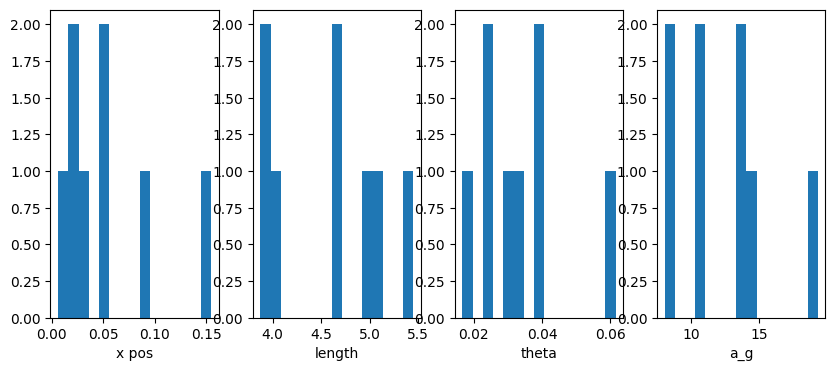

In [87]:
bins = 15

plt.clf()
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(141)
ax.hist(y_noisy, bins=bins)
ax.set_xlabel('x pos')
ax1 = fig.add_subplot(142)
ax1.hist(xs[:,0], bins=bins)
ax1.set_xlabel('length')
ax2 = fig.add_subplot(143)
ax2.hist(xs[:,1], bins=bins)
ax2.set_xlabel('theta')
ax3 = fig.add_subplot(144)
ax3.hist(xs[:,2], bins=bins)
ax3.set_xlabel('a_g')
plt.show()

Now make this into a df with columns for planet number and pendulum number.

In [88]:
data_params = {
    'length': xs[:,0],
    'theta': xs[:,1],
    'a_g': xs[:,2],
    'planet_id': labels[:,0],
    'pendulum_id': labels[:,1]
    
}

## create the DataFrame
df = pd.DataFrame(data_params)
df['pos'] = y_noisy
df['time'] = np.repeat(time,2*length_df)

pend_encoder = LabelEncoder()
df["pend_code"] = pend_encoder.fit_transform(df["pendulum_id"].values)
planet_encoder = LabelEncoder()
df["planet_code"] = planet_encoder.fit_transform(df["planet_id"].values)

planet_code = df["planet_code"].values
pend_obs = df["pos"].values
time_values = df["time"].values
pend_code = df["pend_code"].values

df = df[["length","theta","a_g","pos","pend_code","planet_code","time"]]

df

length     theta        a_g       pos  pend_code  planet_code  time
0  4.640957  0.032502  19.320648  0.006111          0            0  0.75
1  3.979468  0.025327  13.916632  0.016878          1            0  0.75
2  5.453564  0.024340  13.757290  0.049185          2            0  0.75
3  3.885114  0.038813  14.176456  0.020764          3            0  0.75
4  4.995732  0.039700  10.664377  0.090700          4            1  0.75
5  3.872610  0.028916  10.781591  0.035159          5            1  0.75
6  4.632669  0.061568   8.192410  0.154713          6            1  0.75
7  5.076797  0.016671   8.065534  0.049551          7            1  0.75

<Figure size 640x480 with 0 Axes>

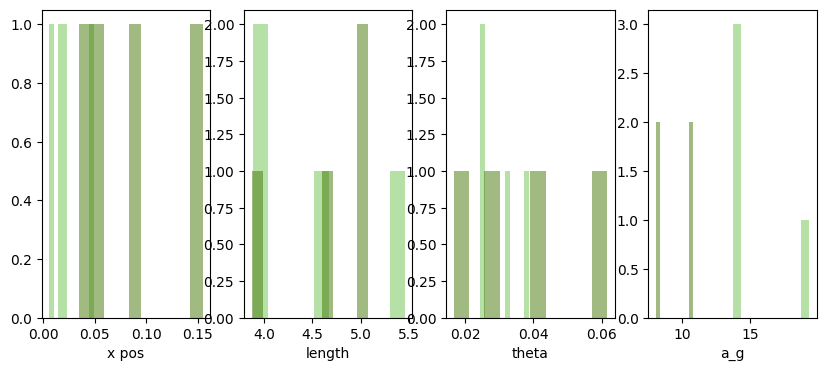

In [89]:
# same thing but separate out by planet
bins = 10
plt.clf()
fig = plt.figure(figsize = (10,4))
ax = fig.add_subplot(141)
ax.hist(df[df['planet_code']==0]['pos'].values, bins=bins, color = '#6CC551', alpha = 0.5)
ax.hist(df[df['planet_code']==1]['pos'].values, bins=bins, color = '#447604', alpha = 0.5)
ax.set_xlabel('x pos')
ax1 = fig.add_subplot(142)
ax1.hist(df[df['planet_code']==0]['length'].values, bins=bins, color = '#6CC551', alpha = 0.5)
ax1.hist(df[df['planet_code']==1]['length'].values, bins=bins, color = '#447604', alpha = 0.5)
ax1.set_xlabel('length')
ax2 = fig.add_subplot(143)
ax2.hist(df[df['planet_code']==0]['theta'].values, bins=bins, color = '#6CC551', alpha = 0.5)
ax2.hist(df[df['planet_code']==1]['theta'].values, bins=bins, color = '#447604', alpha = 0.5)
ax2.set_xlabel('theta')
ax3 = fig.add_subplot(144)
ax3.hist(df[df['planet_code']==0]['a_g'].values, bins=bins, color = '#6CC551', alpha = 0.5)
ax3.hist(df[df['planet_code']==1]['a_g'].values, bins=bins, color = '#447604', alpha = 0.5)
ax3.set_xlabel('a_g')
plt.show()

## Visualize the probabilistic graph
Numpyro has some neat tools for creating DAGS - directive acyclic graphs

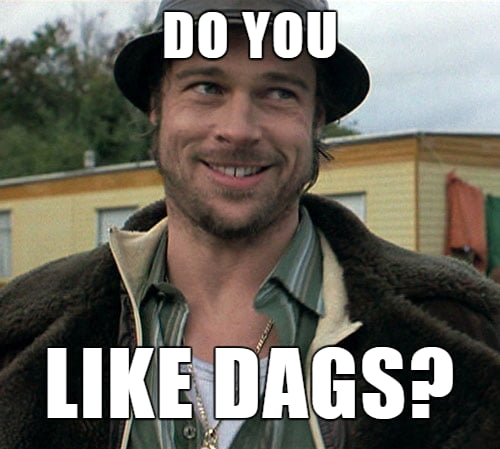

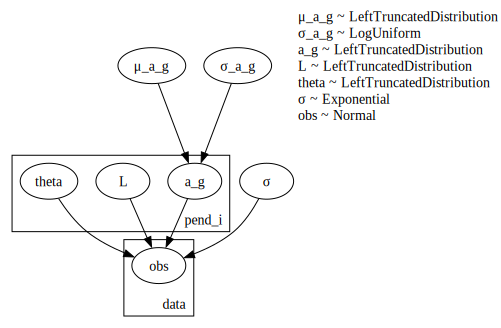

In [79]:
## first simple
numpyro.render_model(
    model=simple_model,
    model_args=(pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

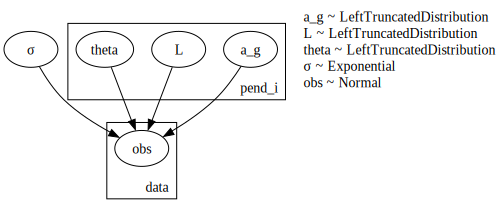

In [101]:
## then without population parameters
numpyro.render_model(
    model=simple_model_no_population,
    model_args=(pend_code, time_values),
    render_distributions=True,
    render_params=True,
)

## Prior predictive distribution
Before running anything, investigate what the prior predictive distribution looks like. This is a way of drawing from the priors that you have set up to see if they are reasonable compared to the data.

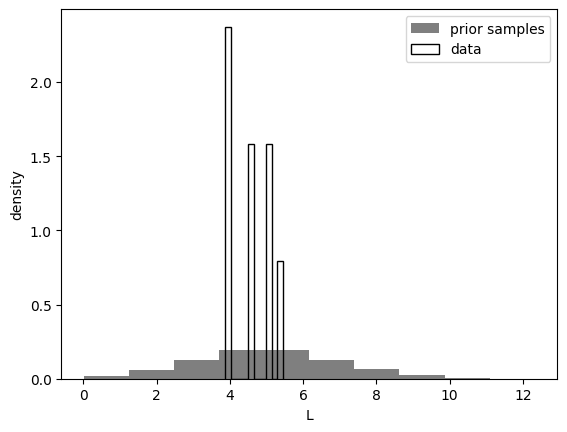

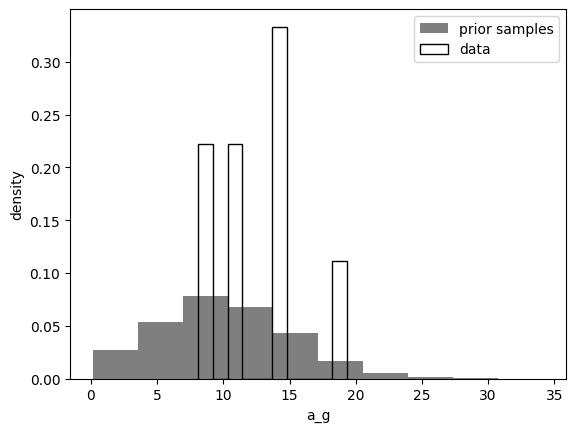

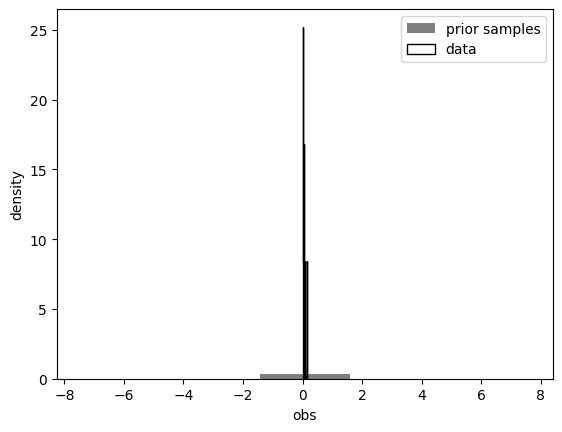

KeyError: 'pos_err'

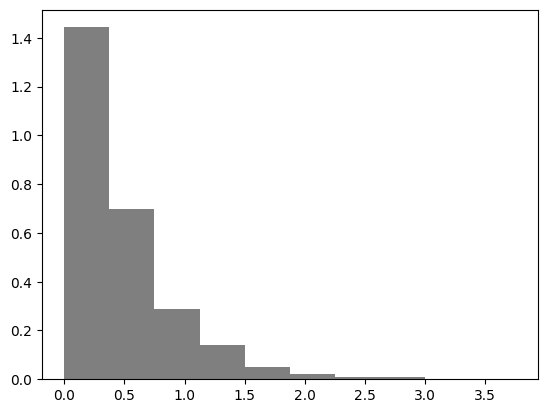

In [90]:
## generate samples from the prior using numpyro.infer.Predictive
## we will give it all the same inputs as the dataset, but this could be done with
## a new dataset

prior_pred = numpyro.infer.Predictive(simple_model, num_samples=1000)(
    random.PRNGKey(11), pend_code, time_values
)

## the plot_prior_predictive helper graph function normalizes the density
## of the true and sampled parameter values so that they each sum to one
plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "σ", "pos_err", n_steps=10, title = None)

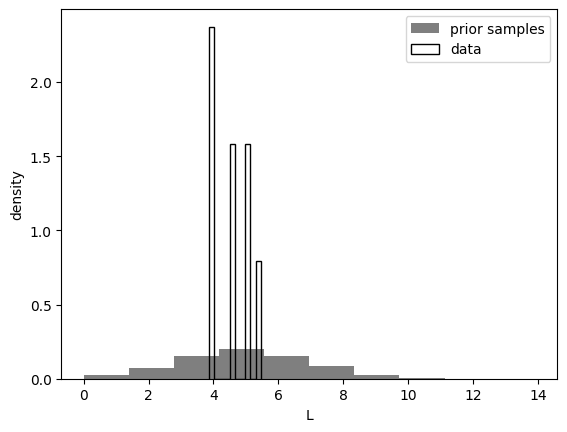

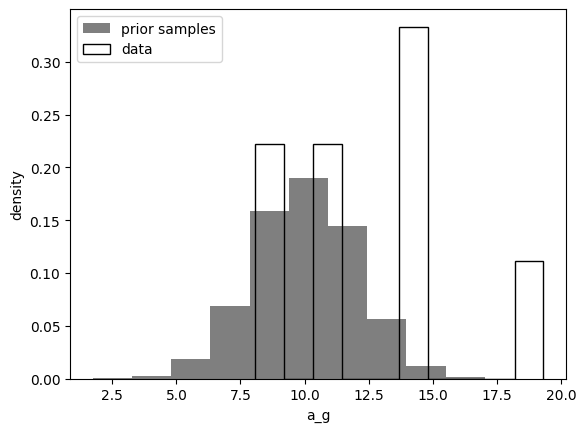

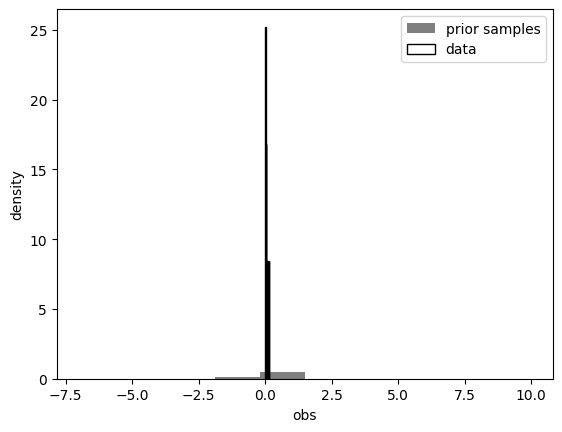

KeyError: 'pos_err'

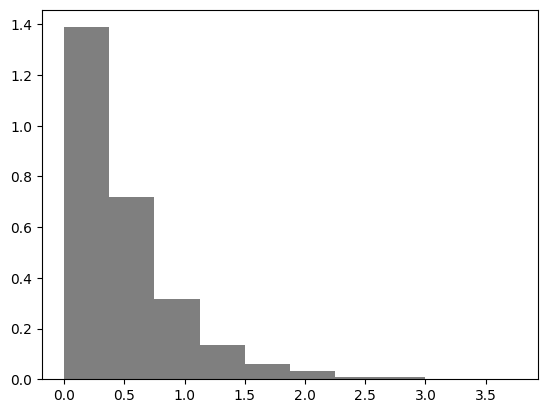

In [102]:
## generate samples from the prior using numpyro.infer.Predictive
## we will give it all the same inputs as the dataset, but this could be done with
## a new dataset

prior_pred = numpyro.infer.Predictive(simple_model_no_population, num_samples=1000)(
    random.PRNGKey(11), pend_code, time_values
)

## the plot_prior_predictive helper graph function normalizes the density
## of the true and sampled parameter values so that they each sum to one
plot_prior_predictive(prior_pred, "L", "length", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "a_g", "a_g", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "obs", "pos", n_steps=10, title = None)
plot_prior_predictive(prior_pred, "σ", "pos_err", n_steps=10, title = None)


## Run the simple inference

In [103]:
## the NUTS (no u-turn sampler) is a type of hamiltonian monte carlo
## method, meaning it knows about potential energy (think gradients)
nuts_kernel = NUTS(simple_model_no_population, init_strategy = numpyro.infer.initialization.init_to_sample)#, target_accept_prob = 0.9)

# can change the target acceptance probability
# default is 0.8 80% 
mcmc = MCMC(nuts_kernel, num_samples=5000, num_warmup=1000, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc.run(rng_key,  pend_code, time_values, pos_obs=pend_obs)

posterior_samples = mcmc.get_samples()

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [104]:
## the arviz tools allows us to investigate the chain performance
inf_data = az.from_numpyro(mcmc)
## zero divergence means energy is conserved
print(f'divergences: {inf_data.sample_stats.diverging.values.sum()}')
az.summary(inf_data)

divergences: 818


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]       3.440  1.563   0.001    6.065      0.054    0.038     763.0   
L[1]       3.800  1.434   1.390    6.930      0.027    0.019    2459.0   
L[2]       4.660  1.318   2.429    7.343      0.020    0.014    3683.0   
L[3]       3.992  1.430   1.632    7.038      0.026    0.020    3864.0   
L[4]       5.473  1.273   3.306    8.044      0.020    0.014    4133.0   
L[5]       4.334  1.361   1.931    7.075      0.016    0.011    6545.0   
L[6]       6.414  1.238   4.218    8.908      0.016    0.011    6147.0   
L[7]       4.650  1.319   2.316    7.278      0.020    0.014    3508.0   
a_g[0]    10.381  1.977   6.644   13.948      0.051    0.036    1541.0   
a_g[1]    10.231  1.963   6.676   14.025      0.043    0.031    2075.0   
a_g[2]    10.082  1.979   6.347   13.641      0.042    0.030    2216.0   
a_g[3]    10.347  1.978   6.685   14.078      0.040    0.031    2550.0   
a_g[4]     9.917  1.933   6.252   13.507      0.027    0.019    5139.0   
a_g[5]    10.230  2.012   6.624   14.160      0.052    0.041    1488.0   
a_g[6]     9.637  1.947   6.083   13.299      0.046    0.032    1854.0   
a_g[7]    10.124  1.900   6.523   13.761      0.021    0.015    8298.0   
theta[0]   0.023  0.015   0.000    0.048      0.000    0.000     807.0   
theta[1]   0.024  0.014   0.002    0.051      0.000    0.000    1243.0   
theta[2]   0.028  0.013   0.007    0.052      0.000    0.000    3706.0   
theta[3]   0.024  0.014   0.002    0.050      0.000    0.000    3088.0   
theta[4]   0.033  0.012   0.012    0.056      0.000    0.000    3061.0   
theta[5]   0.026  0.013   0.004    0.051      0.000    0.000    2957.0   
theta[6]   0.039  0.011   0.019    0.060      0.000    0.000    8144.0   
theta[7]   0.028  0.013   0.006    0.054      0.000    0.000    1132.0   
σ          0.024  0.020   0.003    0.059      0.001    0.000     387.0   

          ess_tail  r_hat  
L[0]         322.0   1.00  
L[1]        2108.0   1.00  
L[2]        6767.0   1.00  
L[3]        5707.0   1.01  
L[4]        5990.0   1.00  
L[5]        6898.0   1.00  
L[6]        7139.0   1.00  
L[7]        7420.0   1.00  
a_g[0]      4557.0   1.00  
a_g[1]      2011.0   1.00  
a_g[2]       756.0   1.00  
a_g[3]       592.0   1.00  
a_g[4]      3864.0   1.00  
a_g[5]       751.0   1.00  
a_g[6]      6993.0   1.00  
a_g[7]      6714.0   1.00  
theta[0]     175.0   1.00  
theta[1]    8733.0   1.00  
theta[2]    8885.0   1.00  
theta[3]    6383.0   1.00  
theta[4]    8852.0   1.00  
theta[5]    8024.0   1.00  
theta[6]    9175.0   1.00  
theta[7]     204.0   1.00  
σ            111.0   1.01

/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_14818/1234332580.py:344: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.axvline(x = az.summary(inf_data)['mean'][num], color = 'black')
/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_14818/1234332580.py:345: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.text(az.summary(inf_data)['mean'][num], height, 'mean', color='black', ha='right', va='top', rotation=90)
/var/folders/5m/wnsjjcln435g2yq5mmxf45k00000gz/T/ipykernel_14818/1234332580.py:346: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integ

KeyboardInterrupt: 

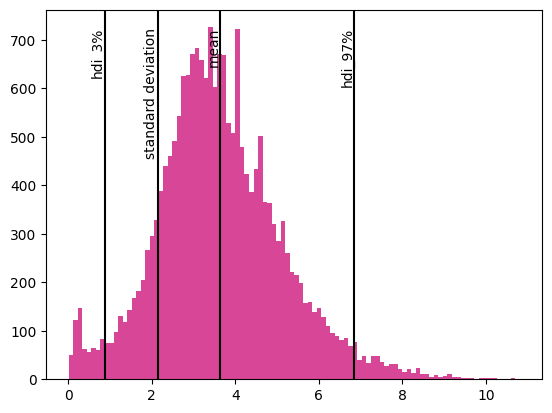

In [93]:
investigate_distribution_posteriors(posterior_samples, inf_data)

## Interpreting the arviz table
The first two columns are the mean and standard deviation of each parameter, taken from examining all four chains.

- hdi = the high density interval, which is the minimum width Bayesian credible interval (BCI)

The best description I've found for it:

The HDI is the interval which contains the required mass such that all points within the interval have a higher probability density than points outside the interval. In contrast, a symmetric density interval defined by (eg.) the 10% and 90% quantiles may include values with lower probability than those excluded.


- mcse = markov chain standard error

- ess = effective sample size

This is equal to the sample size if all samples are independent. Here, the values are quite low for the different parameters, which indicates that we have very few indpendent draws. Does this mean we need to length the chains? Maybe.

- rhat = rank normalized splitR-hat for a set of traces (https://arxiv.org/pdf/1903.08008.pdf)

The rank normalized R-hat diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical. To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.

rhat ~ sqrt(1 + Nchains/ESS), 


so ESS/Nchains ~ 1/2/(rhat - 1), which means that if rhat = 1.05 then ESS/Nchains = 10, which isn’t very big

<Figure size 640x480 with 0 Axes>

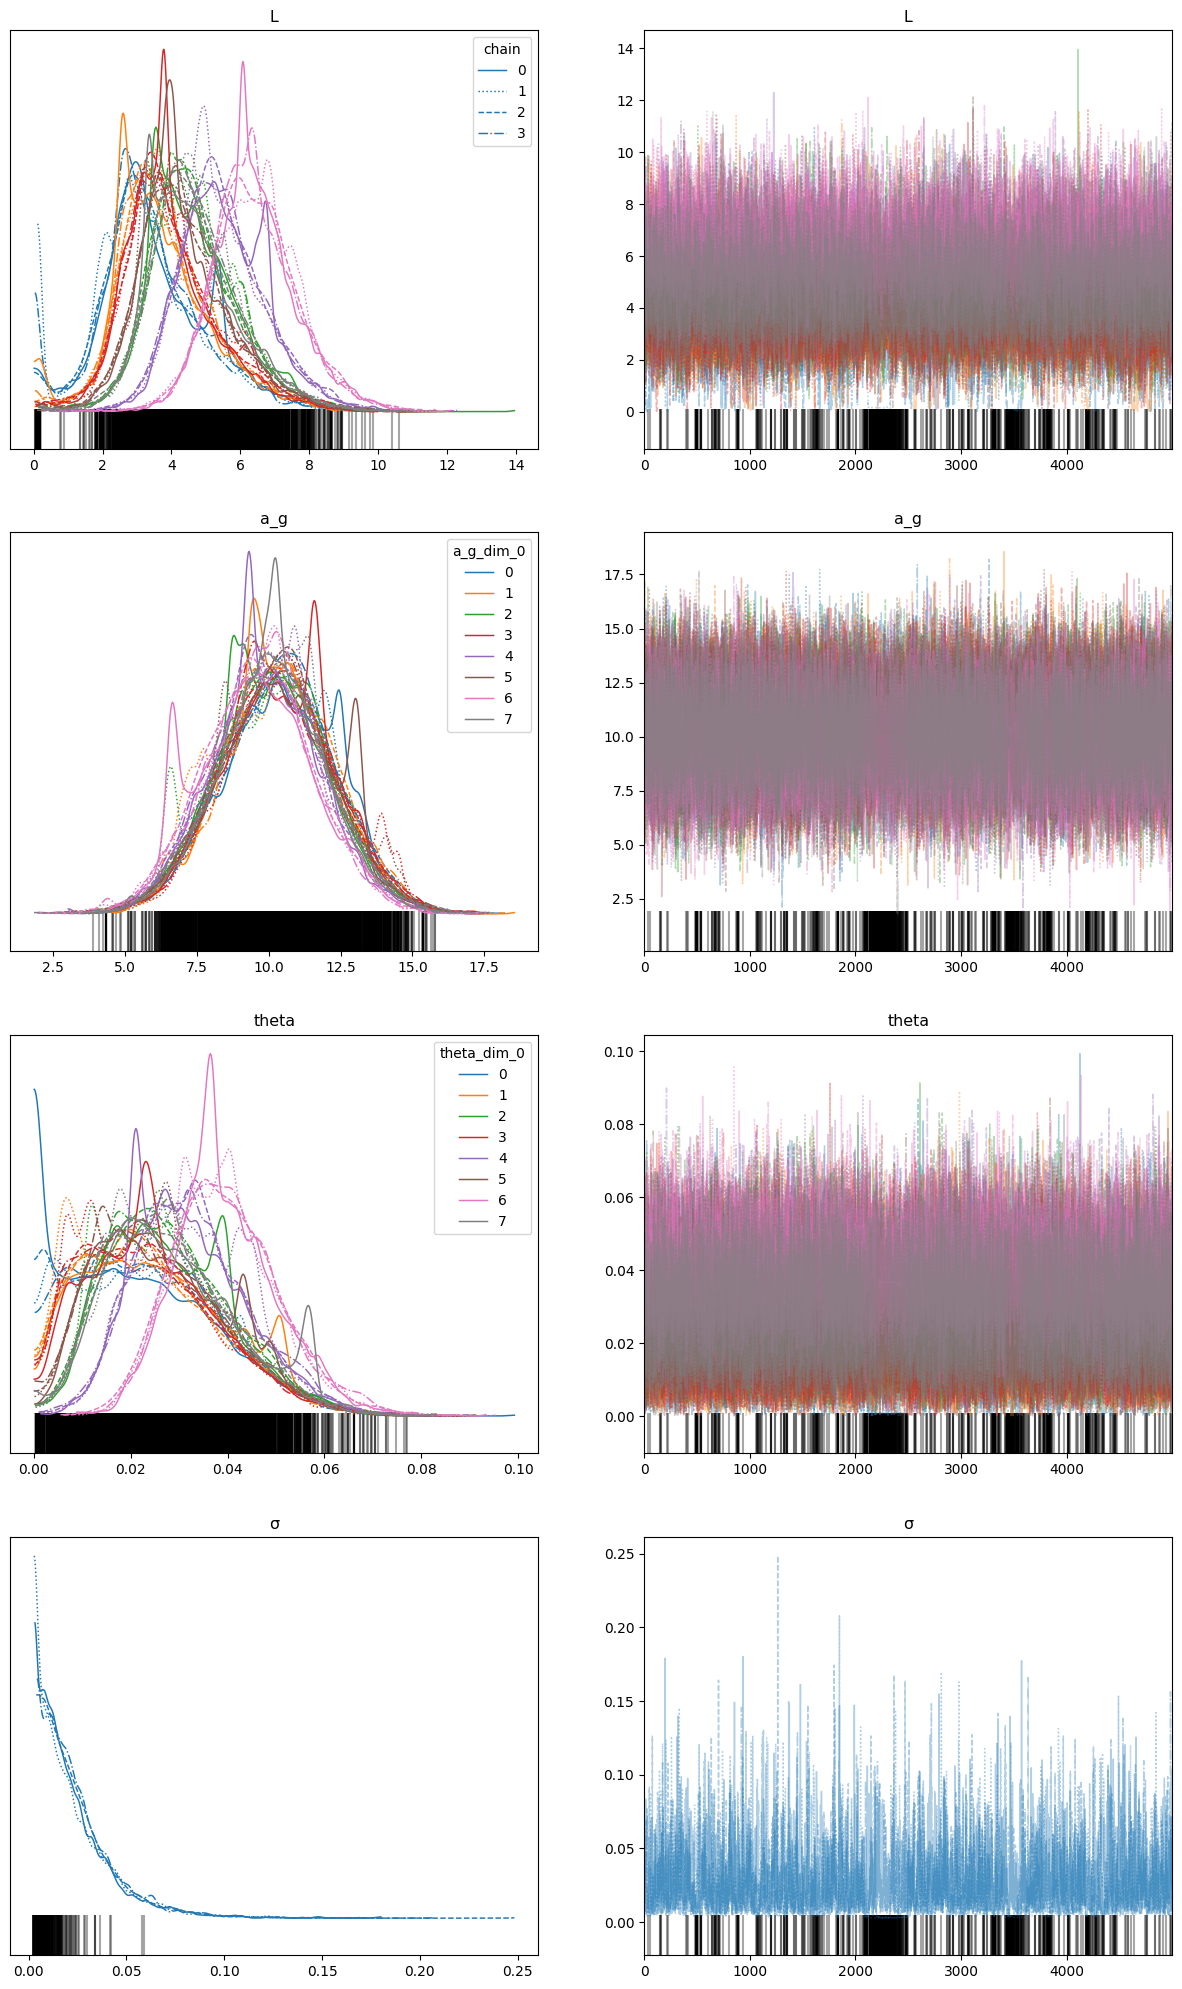

In [105]:
data = az.from_numpyro(mcmc)
plt.clf()
az.plot_trace(data, compact=True, figsize=(15, 25), legend=True)
plt.show()

## Visualize it
Some of the classic ways to visualize the output don't work super well with a million pendulums

In [106]:
# so there are sampler chains for each group
#print('shape of L samples', np.shape(mcmc.get_samples()['L']))
print('shape of a_g samples', np.shape(mcmc.get_samples()['a_g']))

shape of a_g samples (20000, 8)


<Figure size 640x480 with 0 Axes>

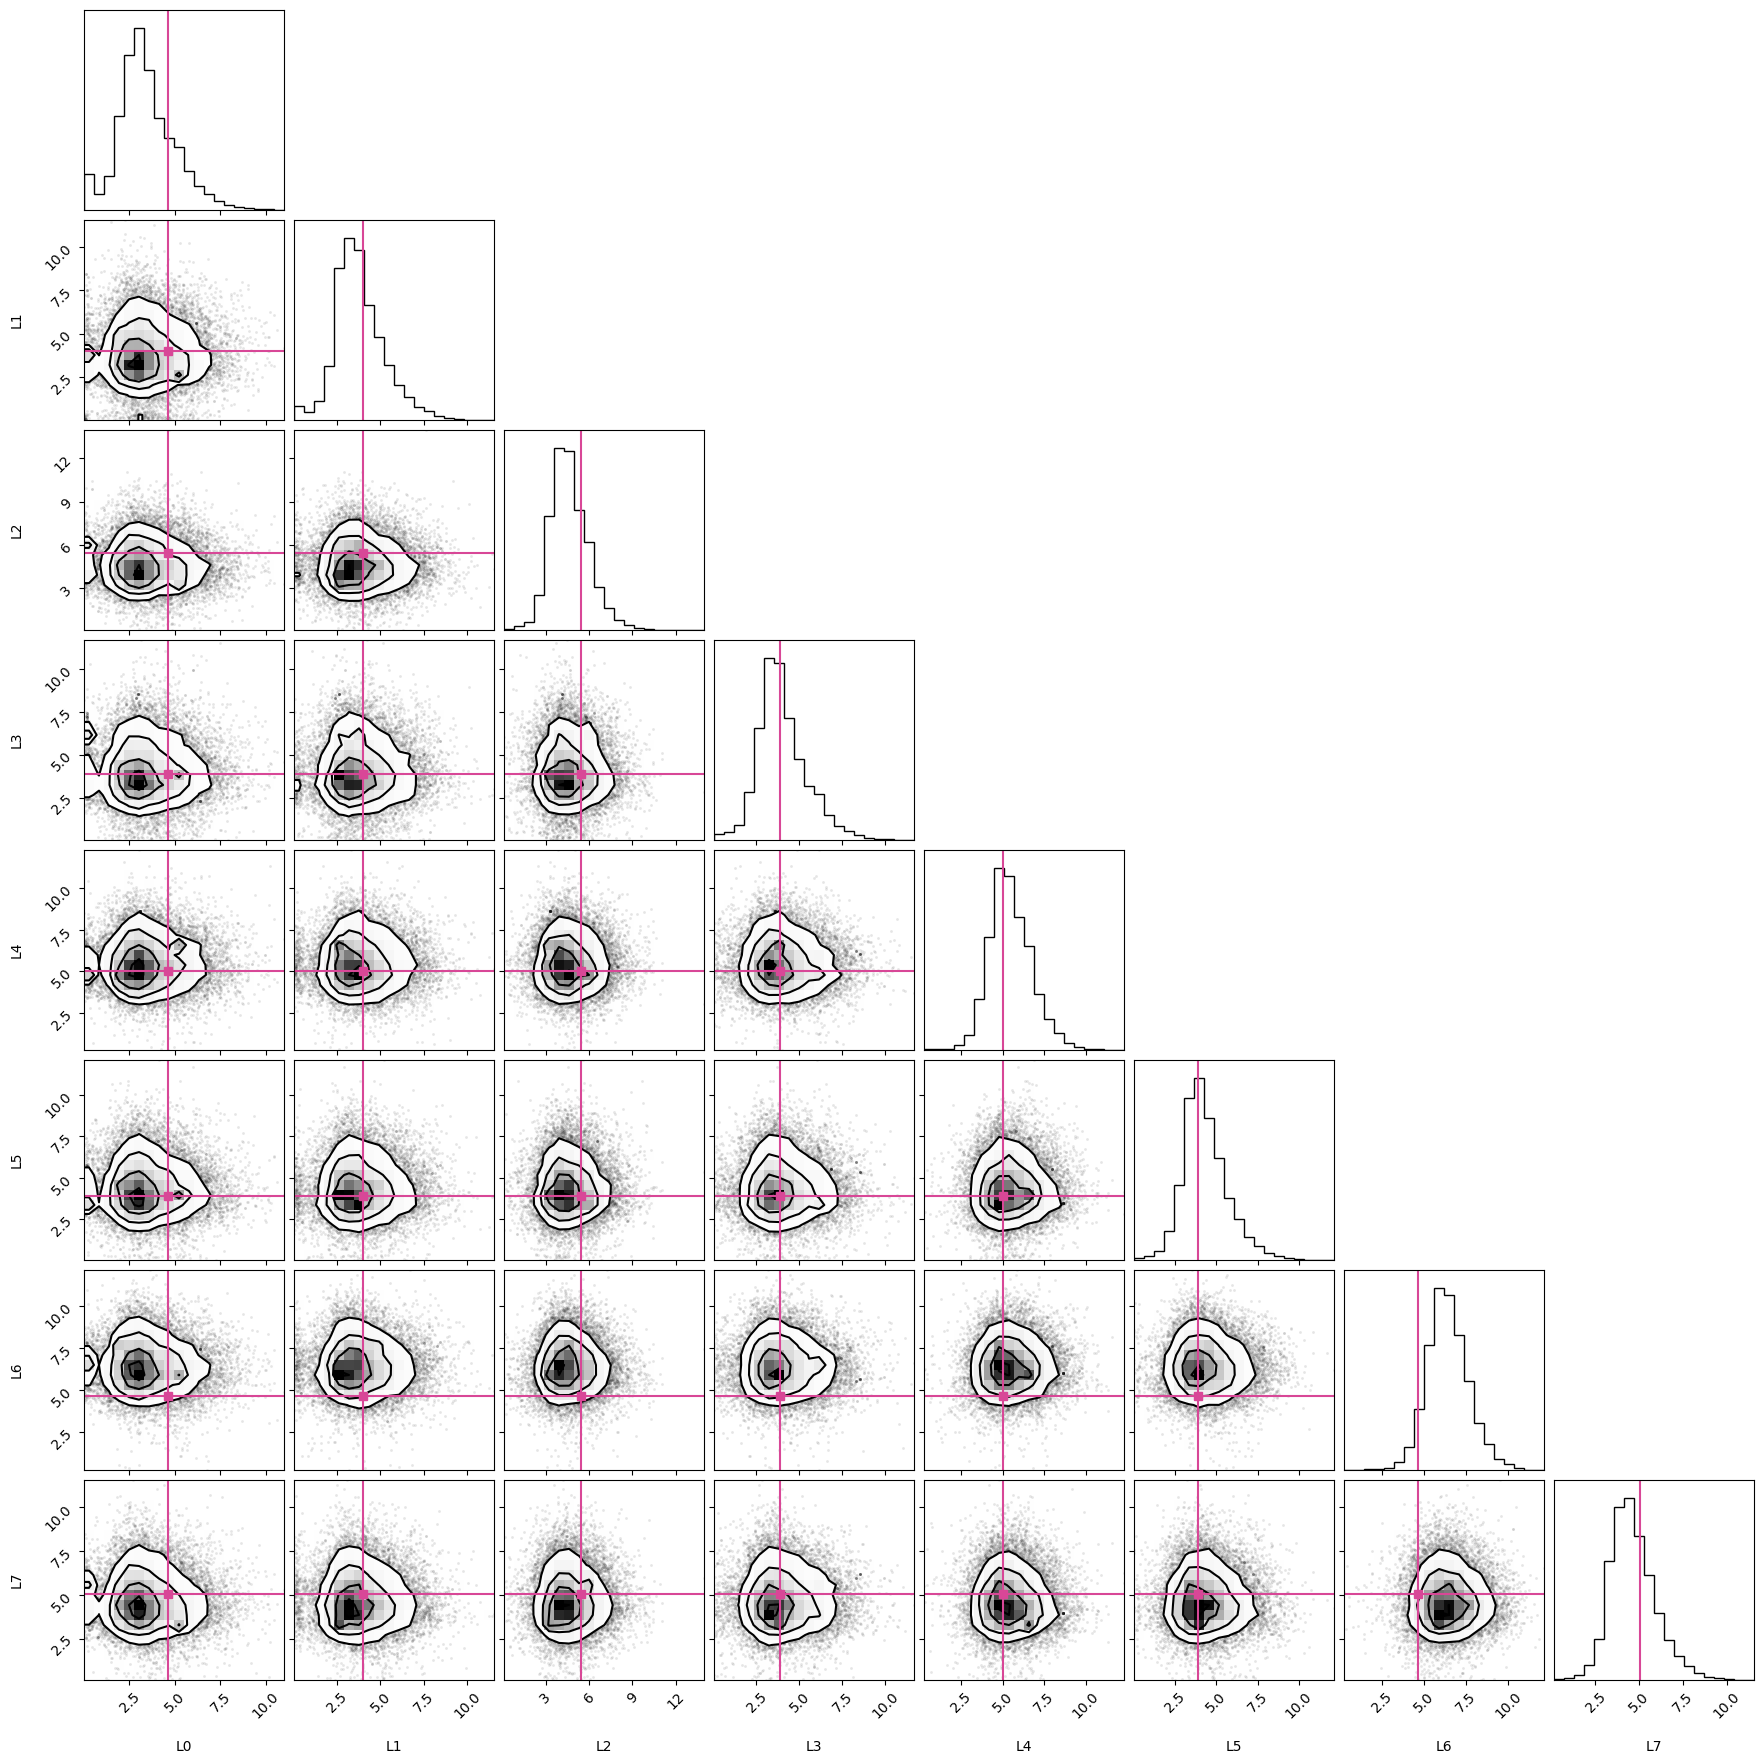

<Figure size 640x480 with 0 Axes>

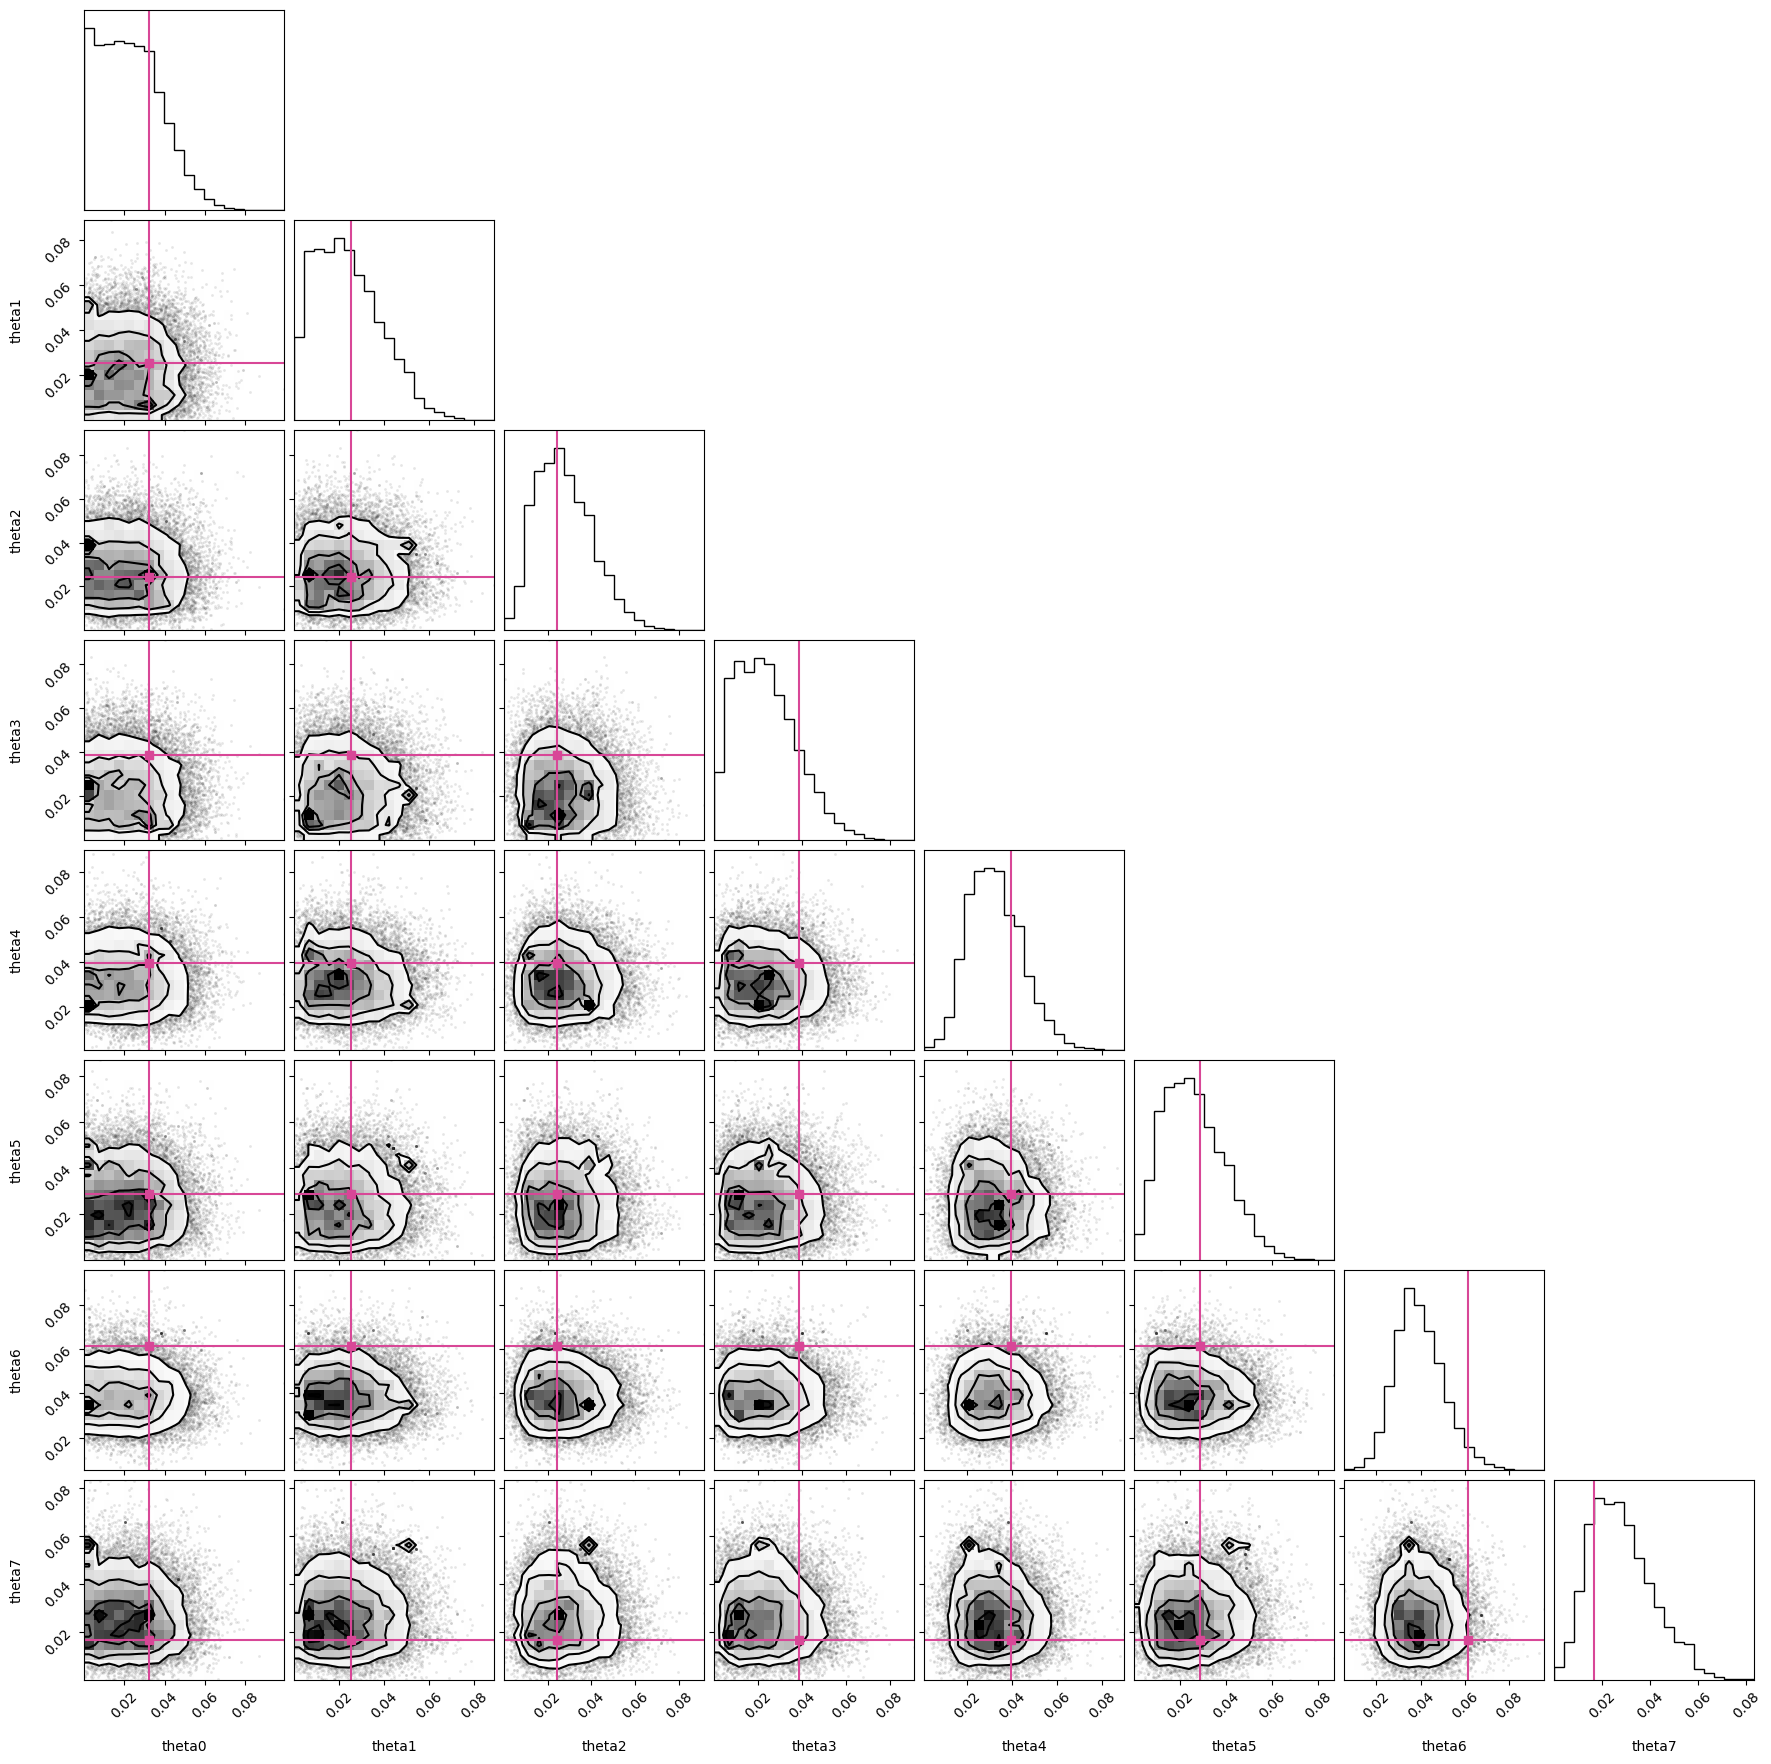

[19.32064803 13.91663219 13.75728979 14.17645561 10.66437723 10.7815907
  8.1924101   8.06553429]


<Figure size 640x480 with 0 Axes>

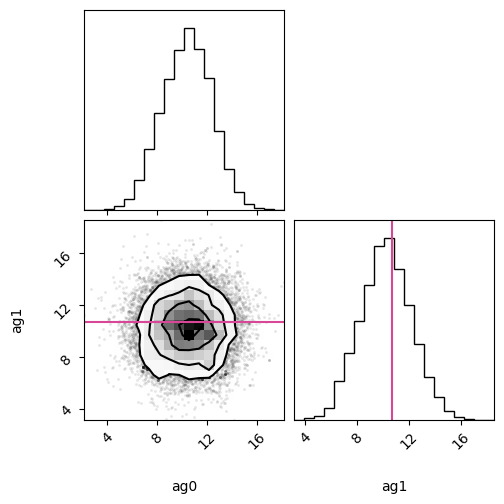

<Figure size 640x480 with 0 Axes>

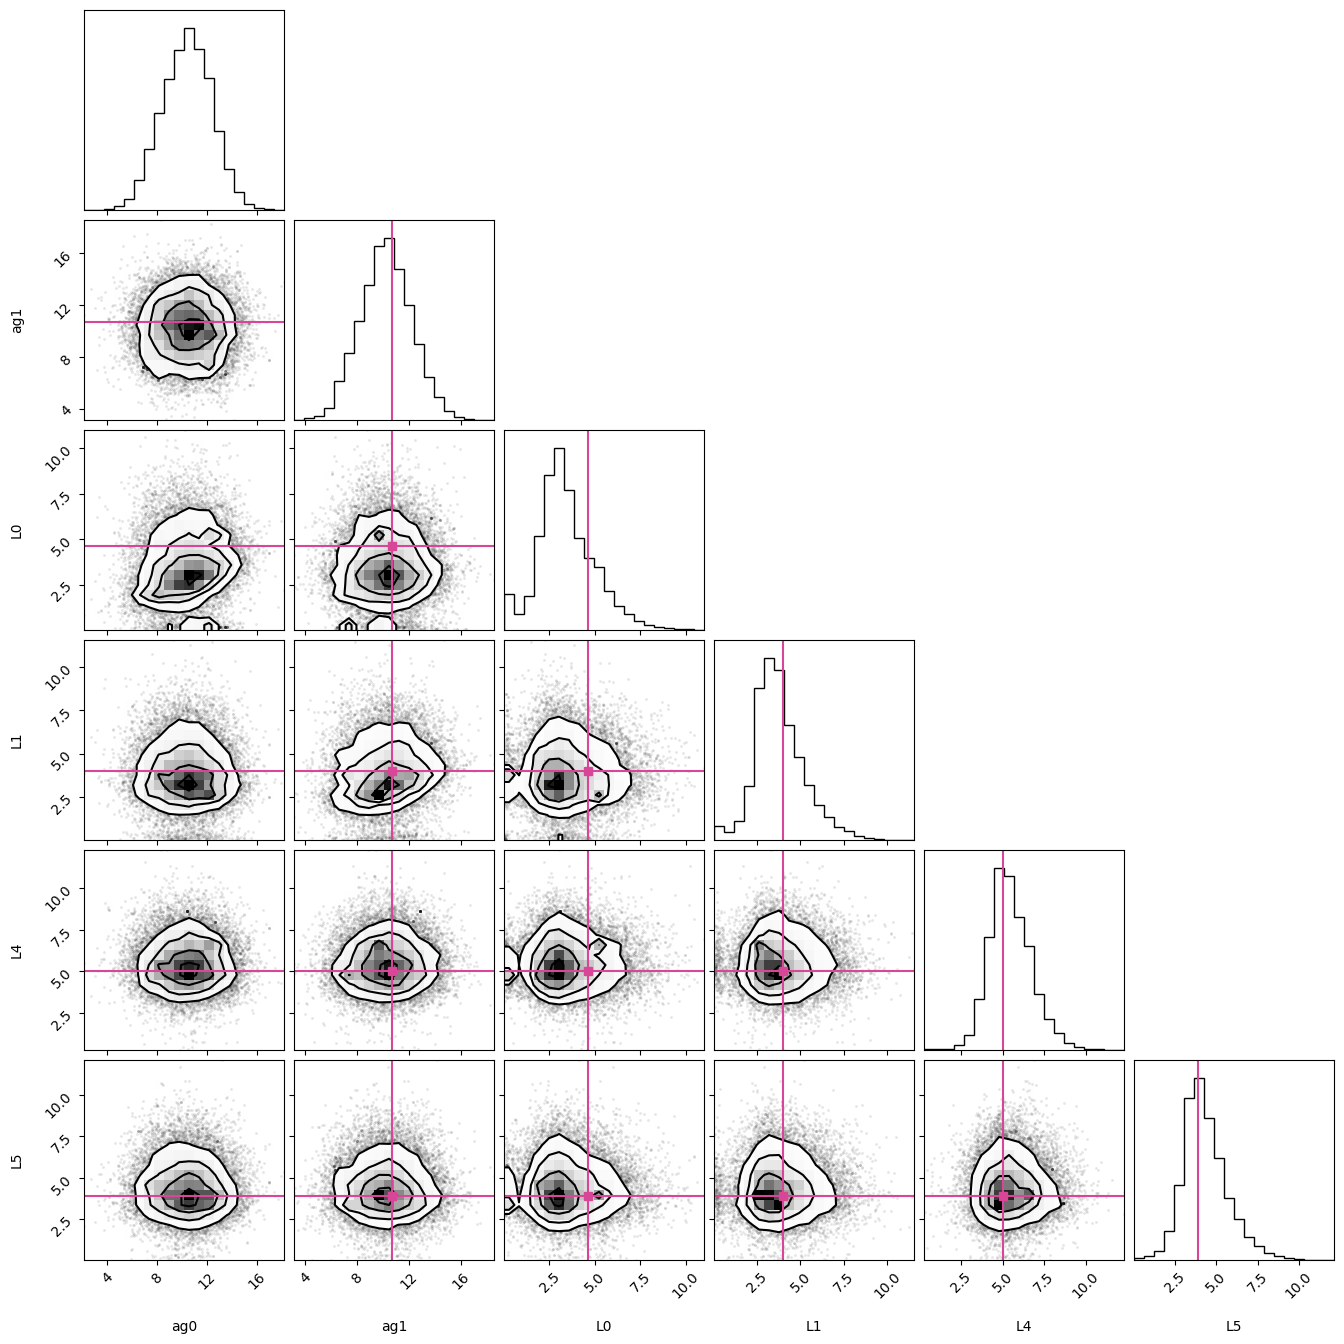

In [107]:
# take a look at the posterior
make_corner_plots(posterior_samples, data_params)

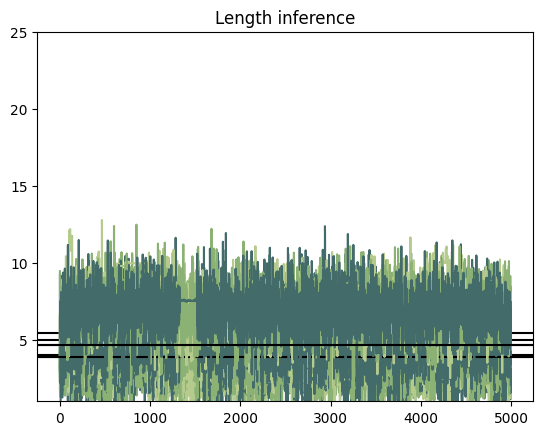

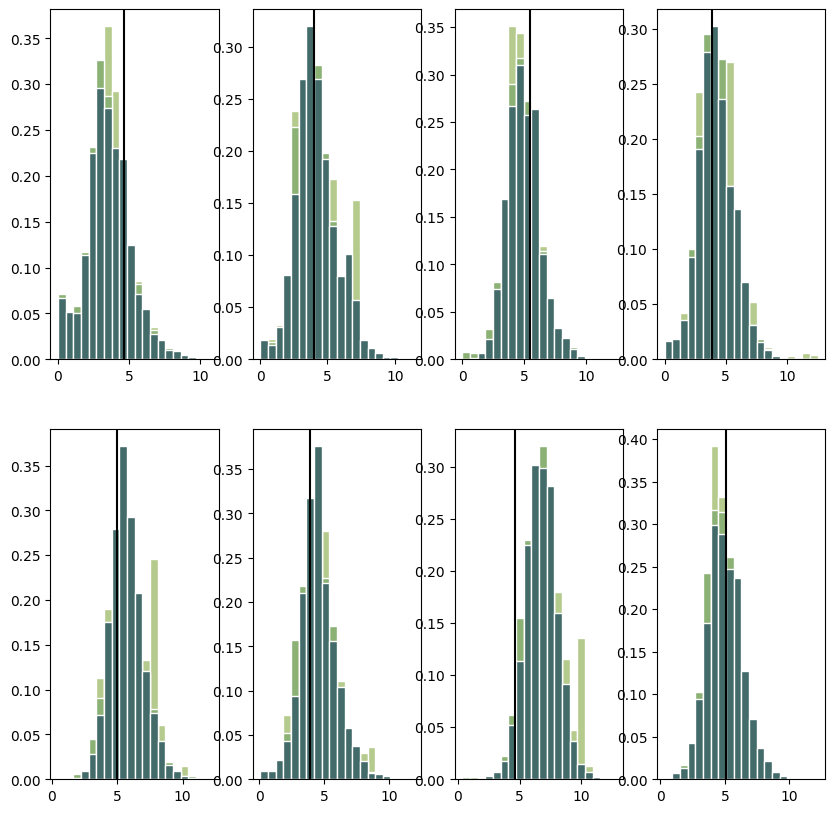

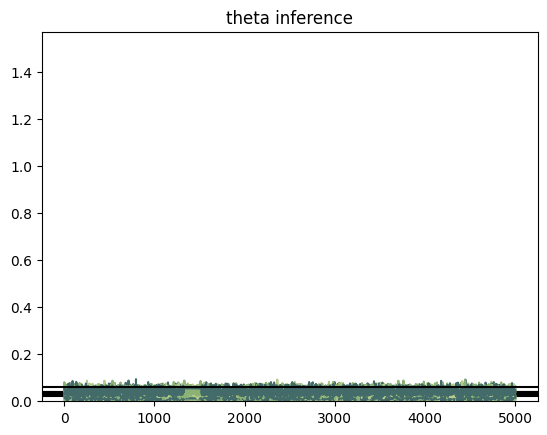

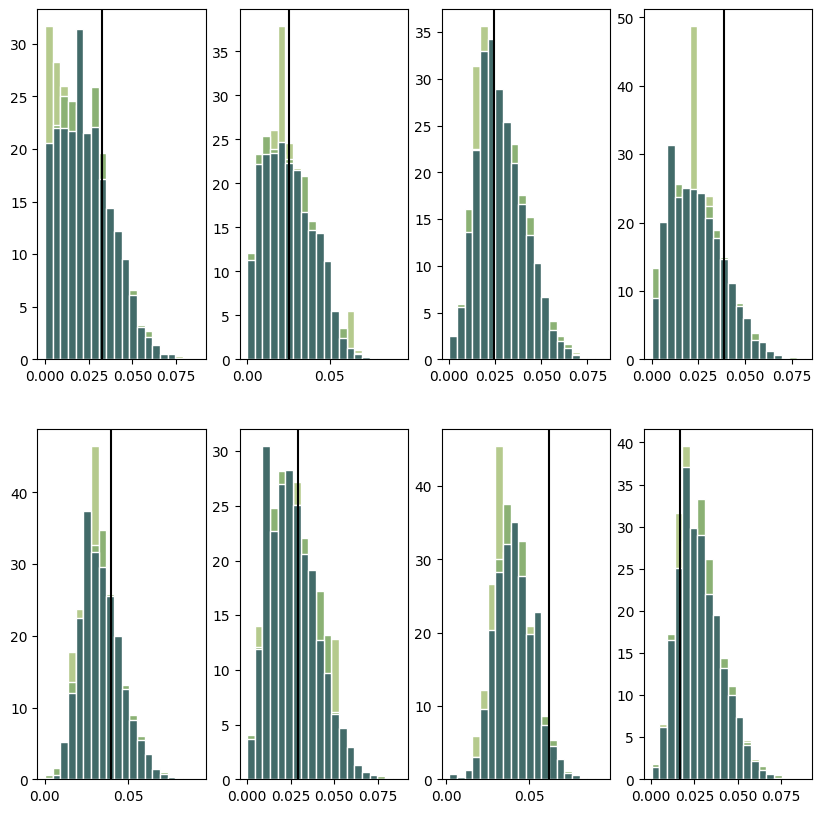

In [99]:
# Let's come up with a better way to show all seven pendulums sampling result in histogram form
# for the separate 4 chains
#def examine_chains(posterior, data_params, n_pendulums = 8, chain_length = 5000, n_chains = 4):

examine_chains(posterior_samples, data_params)


In [ ]:
# how did we do at predicting the trajectory?
#how_did_we_do_on_individual_pendulums(df, posterior, 8, 2000)
how_did_we_do_on_all_pendulums(df, posterior_hierarchical, 8, 2000)

In [ ]:
# plot the posterior predictive samples
# get posterior predictive samples

hierarachical_posterior_predictive, hierarchical_posterior_predictive_samples, hierarchical_idata = plot_posterior_predictive_samples(df,
                                  hierarchical_model,
                                  posterior_hierarchical,
                                  rng_key,
                                  time_values,
                                  mcmc_hierarchical,
                                  pooled = False,
                                  title = "Hierarchical Model Posterior Predictive Check")

In [ ]:
# plot for each individual planet
print(hierarachical_posterior_predictive)
print(hierarchical_posterior_predictive_samples)
print(np.shape(posterior_hierarchical['L'][:,0]))


nbins = 20

plt.clf()
value, bin_center = np.histogram(hierarchical_posterior_predictive_samples['obs'].flatten()[:], bins = nbins)
plt.hist(hierarchical_posterior_predictive_samples['obs'].flatten()[:],
         bins = bin_center,
         color = '#6C969D', alpha = 0.5,
         label = 'Model posterior', 
         density = True,
         histtype='bar', ec='white')
plt.hist(df["pos"].values,
         bins = bin_center,
         color = '#99D5C9', alpha = 0.5,
         label = 'Obs',
         density = True,
         histtype='bar', ec='white')
plt.legend()
plt.show()

STOP
fig, axes = plt.subplots(
    nrows=1, ncols=2, figsize=(10, 6), sharex=False, sharey=False, layout="constrained"
)

axes = axes.flatten()

for location in range(1, 2 + 1):
    ax = axes[location - 1]
    sns.histplot(
        x=hierarchical_posterior_predictive_samples["a_g"][:, location - 1],
        color=f"C{location - 1}",
        ax=ax,
    )
    ax.set(title=f"Planet {location}", xlabel="a_g", ylabel="count")

fig.suptitle("Hierarchical Model Prior Predictive Samples", y=1.05, fontsize=16)

## Now run the inference for the ungrouped case

In [47]:
# higher acceptance means smaller step size
# Target acceptance probability for step size adaptation using Dual Averaging. 
# Increasing this value will lead to a smaller step size, hence the sampling will be slower but more robust.
# Defaults to 0.8.
nuts_kernel_ungrouped = NUTS(ungrouped_model, target_accept_prob = 0.8)

mcmc_unpooled = MCMC(nuts_kernel_ungrouped, num_samples=5000, num_warmup=5000, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc_unpooled.run(rng_key, pend_code, time_values, pos_obs=pend_obs)


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [49]:
inf_data_ungrouped = az.from_numpyro(mcmc_unpooled)
az.summary(inf_data_ungrouped)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
L[0]       5.922  3.276   1.005   11.788      1.033    0.753      10.0   
L[1]       9.045  4.880   1.163   17.643      1.541    1.123      10.0   
L[2]      13.367  7.504   1.013   22.065      3.061    2.295       7.0   
L[3]      13.409  7.640   1.047   22.412      3.236    2.434       7.0   
L[4]       4.593  2.654   1.002    9.925      0.777    0.564      12.0   
L[5]       5.034  3.136   1.118    9.189      1.352    1.037       7.0   
L[6]       6.730  3.684   1.002   11.998      1.305    0.959       9.0   
L[7]       8.431  5.350   1.518   15.367      2.279    1.734       7.0   
a_g[0]     5.733  5.574  -0.066   16.523      2.164    1.603       6.0   
a_g[1]     5.623  5.657  -0.605   16.396      2.231    1.655       6.0   
a_g[2]     5.267  5.257   0.067   16.183      2.124    1.580       6.0   
a_g[3]     4.892  5.516   0.078   16.213      2.292    1.711       5.0   
a_g[4]     6.206  5.201   1.453   16.571      1.904    1.403       6.0   
a_g[5]     5.415  5.977  -1.743   16.314      2.457    1.831       6.0   
a_g[6]     5.323  6.097  -1.998   16.311      2.496    1.859       6.0   
a_g[7]     6.053  5.250   1.216   16.388      1.936    1.427       6.0   
theta[0]   0.132  0.089   0.025    0.254      0.038    0.029       7.0   
theta[1]   0.142  0.104   0.025    0.286      0.045    0.034       7.0   
theta[2]   0.366  0.534   0.004    1.285      0.266    0.204       5.0   
theta[3]   0.310  0.445   0.003    1.074      0.221    0.170       5.0   
theta[4]   0.396  0.525   0.028    1.301      0.262    0.201       6.0   
theta[5]   0.301  0.373   0.028    0.942      0.185    0.143       6.0   
theta[6]   0.233  0.246   0.028    0.646      0.120    0.094       6.0   
theta[7]   0.416  0.552   0.029    1.365      0.274    0.211       6.0   
μ_a_g      7.996  4.114   1.705   15.816      1.501    1.105       8.0   
σ          0.092  0.054   0.010    0.160      0.027    0.021       4.0   
σ_a_g      2.804  1.338   0.263    4.779      0.262    0.187      58.0   

          ess_tail  r_hat  
L[0]          48.0   1.32  
L[1]          61.0   1.32  
L[2]          27.0   1.55  
L[3]          28.0   1.60  
L[4]          68.0   1.61  
L[5]         140.0   1.62  
L[6]          58.0   1.38  
L[7]         119.0   1.60  
a_g[0]         4.0   1.93  
a_g[1]         4.0   1.92  
a_g[2]        29.0   1.78  
a_g[3]         4.0   2.24  
a_g[4]         4.0   1.91  
a_g[5]         4.0   1.92  
a_g[6]         4.0   1.92  
a_g[7]         4.0   1.93  
theta[0]      52.0   1.65  
theta[1]      62.0   1.64  
theta[2]      26.0   2.65  
theta[3]      26.0   2.94  
theta[4]      76.0   1.90  
theta[5]      62.0   1.90  
theta[6]      60.0   1.91  
theta[7]      61.0   1.92  
μ_a_g         49.0   1.49  
σ             29.0   3.17  
σ_a_g       1087.0   1.09

/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/rnevin/Library/Caches/pypoetry/virtualenvs/deepuq-DRzT0TL8-py3.9/lib/python3.9/site-packages/arviz/stats/density_utils.py:487: Us

<Figure size 640x480 with 0 Axes>

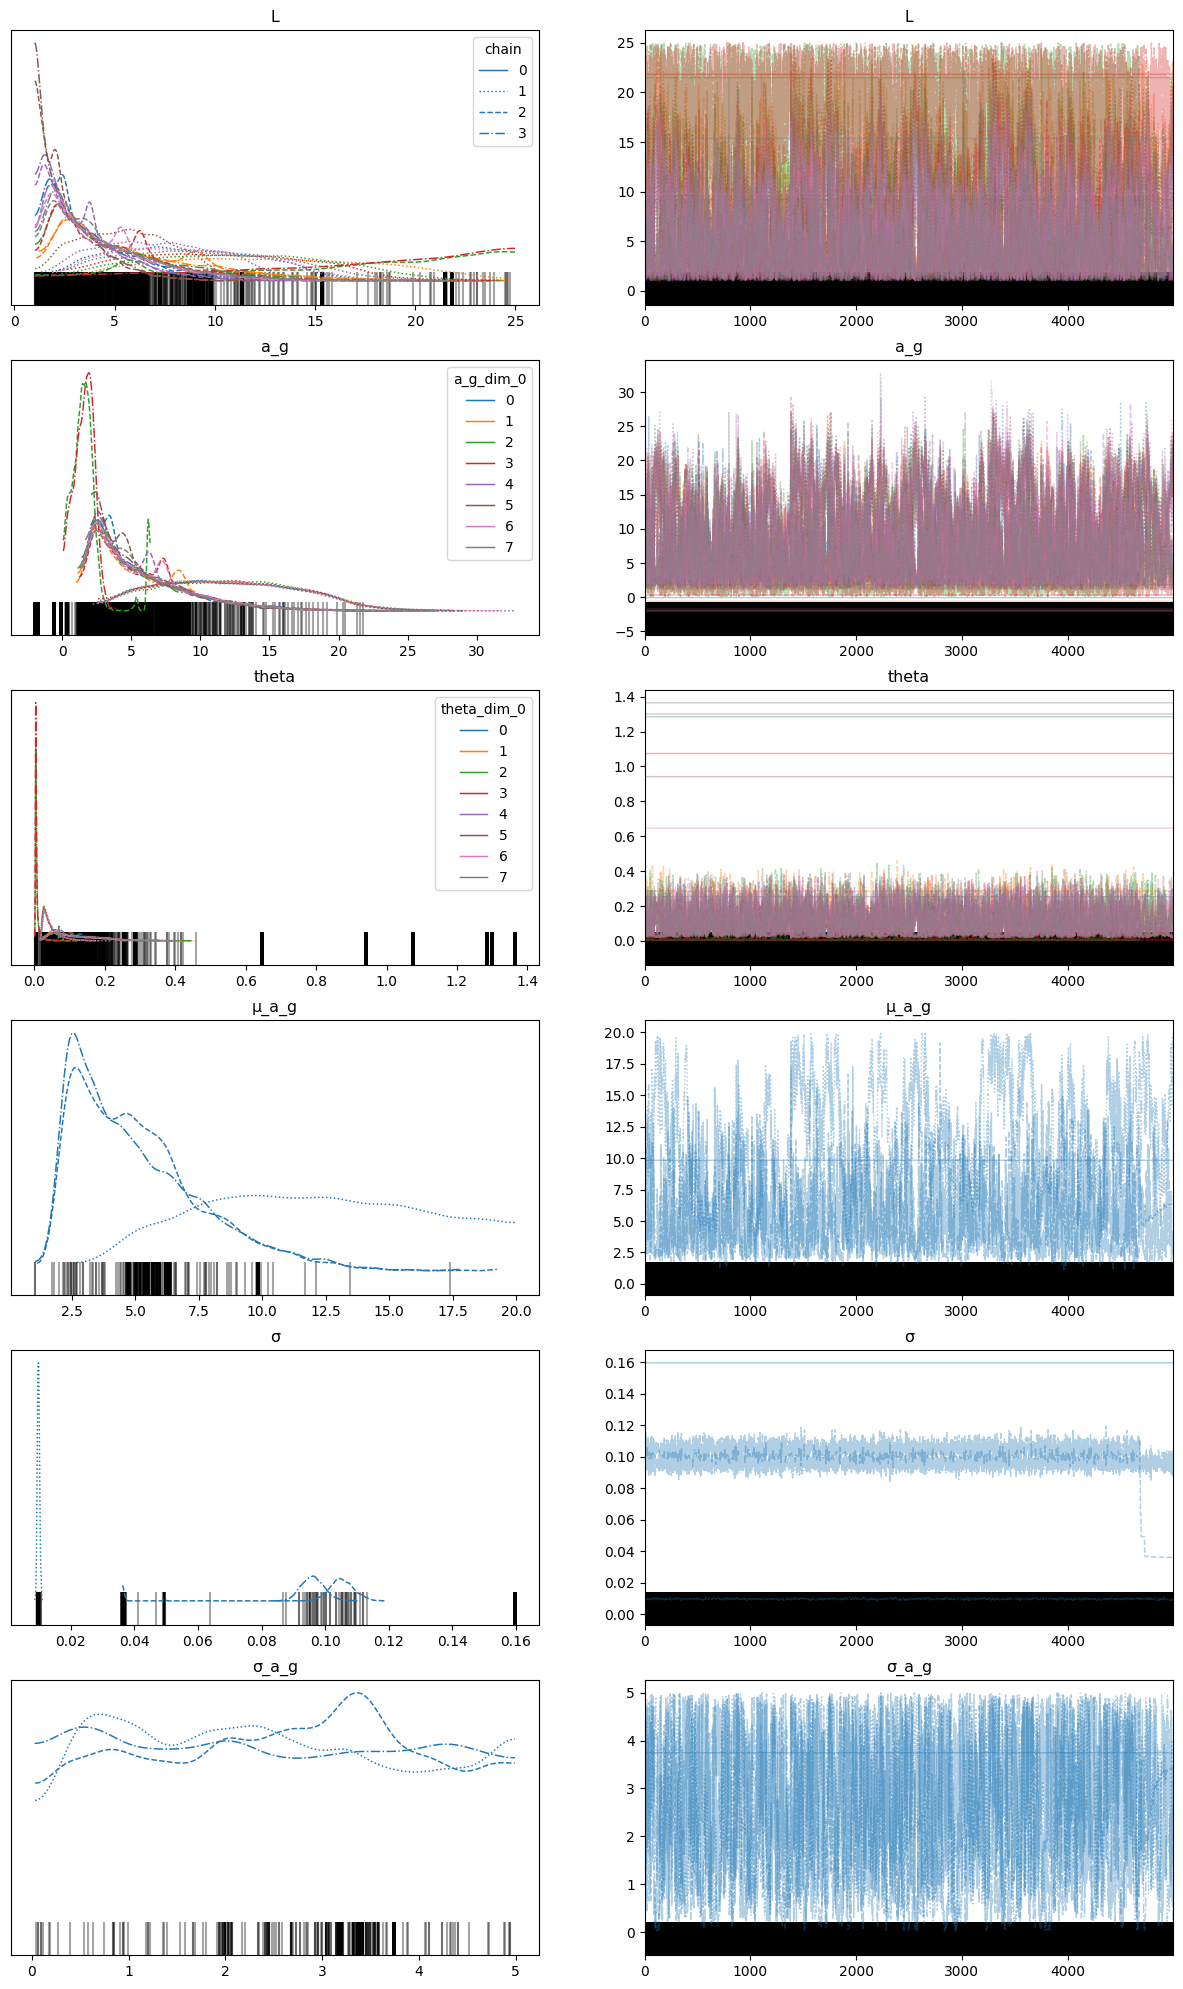

In [51]:
data_ungrouped = az.from_numpyro(mcmc_unpooled)
plt.clf()
az.plot_trace(data_ungrouped, compact=True, figsize=(15, 25), legend=True)
plt.show()

In [ ]:
posterior_ungrouped = mcmc_ungrouped.get_samples()

In [ ]:
# take a look at the posterior
make_corner_plots(posterior_ungrouped, data_params)

## Now run the inference for the unpooled (non-hierarchical) case

In [ ]:
# higher acceptance means smaller step size
# Target acceptance probability for step size adaptation using Dual Averaging. 
# Increasing this value will lead to a smaller step size, hence the sampling will be slower but more robust.
# Defaults to 0.8.
nuts_kernel_unpooled = NUTS(unpooled_model, target_accept_prob = 0.8)

mcmc_unpooled = MCMC(nuts_kernel_unpooled, num_samples=5000, num_warmup=5000, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc_unpooled.run(rng_key, planet_code, pend_code, time_values, pos_obs=pend_obs)


In [ ]:
inf_data_unpooled = az.from_numpyro(mcmc_unpooled)
az.summary(inf_data_unpooled)

In [ ]:
data_unpooled = az.from_numpyro(mcmc_unpooled)
plt.clf()
az.plot_trace(data_unpooled, compact=True, figsize=(15, 25), legend=True)
plt.show()

In [ ]:
posterior_unpooled = mcmc_unpooled.get_samples()

In [ ]:
# take a look at the posterior
make_corner_plots(posterior_unpooled, data_params)

In [ ]:
examine_chains(posterior_unpooled, data_params, chain_length = 5000)

In [ ]:
# there is something bad going on with this posterior
# "too few points to create valid contours"
investigate_distribution_posteriors(posterior_unpooled, inf_data_unpooled)


In [ ]:
# how did we do at predicting the trajectory?
#how_did_we_do_on_individual_pendulums(df, posterior_unpooled, 8, 2000)
how_did_we_do_on_all_pendulums(df, posterior_unpooled, 8, 2000)

In [ ]:
# plot the posterior predictive samples
# get posterior predictive samples

unpooled_posterior_predictive, unpooled_posterior_predictive_samples, unpooled_idata = plot_posterior_predictive_samples(df,
                                  unpooled_model,
                                  posterior_unpooled,
                                  rng_key,
                                  time_values,
                                  mcmc_unpooled,
                                  pooled = False,
                                  kind = "kde",
                                  title = "Unpooled Model Posterior Predictive Check",
                                                  )

## Trying the fully pooled model

In [ ]:
nuts_kernel_pooled = NUTS(pooled_model)

mcmc_pooled = MCMC(nuts_kernel_pooled, num_samples=5000, num_warmup=5000, num_chains = 4)
rng_key = random.PRNGKey(11)
mcmc_pooled.run(rng_key, pend_code, time_values, pos_obs=pend_obs)


In [ ]:
inf_data_pooled = az.from_numpyro(mcmc_pooled)
az.summary(inf_data_pooled)

In [ ]:
data_pooled = az.from_numpyro(mcmc_pooled)
plt.clf()
az.plot_trace(data_pooled, compact=True, figsize=(15, 25), legend=True)
plt.show()

In [ ]:
posterior_pooled = mcmc_pooled.get_samples()

In [ ]:
# take a look at the posterior
make_corner_plots(posterior_pooled, data_params, pooled = True)

In [ ]:
examine_chains(posterior_pooled, data_params)

In [ ]:
# how did we do at predicting the trajectory?
#how_did_we_do_on_individual_pendulums(df, posterior_pooled, 8, 2000, pooled = True)
how_did_we_do_on_all_pendulums(df, posterior_pooled, 8, 2000)

In [ ]:
# plot the posterior predictive samples
# get posterior predictive samples
pooled_idata = plot_posterior_predictive_samples(df,
                                  pooled_model,
                                  posterior_pooled,
                                  rng_key,
                                  time_values,
                                  mcmc_pooled,
                                  pooled = True,
                                  kind = 'kde',
                                  title = "Pooled Model Posterior Predictive Check",
                                  )

## Lets compare all models

In [ ]:
# What is a posterior predictive check?
# comparing the cumulative x positions from the data to those generated from 
# the posterior distribution
# some say this is using the data twice - 1. to generate the thetas, 2. to check again
compare_models(pooled_idata, unpooled_idata, hierarchical_idata, kind = 'cumulative')

In [ ]:
def pos_calculator_integer(L, theta, a_g, sigma, time):
    print('this is the cosine arg', np.sqrt(a_g / L), 'cosine of this', np.cos(np.sqrt(a_g / L)))
    print('this is the sine arg', theta * np.cos(np.sqrt(a_g / L)) * time, 'sine of this', np.sin(theta * np.cos(np.sqrt(a_g / L)) * time))
    pos = L * np.sin(theta * np.cos(np.sqrt(a_g / L) * time)) + sigma
    return pos

'''
theta_time = starting_angle_values * np.cos(
            np.sqrt(acceleration_values / pendulum_arm_length_values)
        )

        # Calculate x using the modified parameters and time
        return pendulum_arm_length_values * np.sin(theta_time * time)

'''
L = 10
theta = np.pi / 2
a_g = 10
sigma = 0.05
times = 0
print(pos_calculator_integer(L,theta,a_g,sigma,times))